# 시계열 데이터 분석(정석)
## 1. 작업 준비
### 1) 패키지 및 데이터 가져오기

In [1]:
from pandas import read_excel
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import seaborn as sb
import sys

In [2]:
df = read_excel("https://data.hossam.kr/E06/air_passengers.xlsx", 
                index_col="Month")
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### 2) 그래프 초기화

In [3]:
plt.rcParams['font.family'] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.unicode_minus'] = False

## 2. ARIMA 분석 수행
- 시계열 데이터를 계절 ARIMA 모델에 맞추려고 할 떄,
    - 첫 번째 목표는 측정항목을 최적화하는 `ARIMA(p, d, q)(P, D, Q, s)` 값을 찾는 것이다.

- `ARIMA(컬럼, order =(p, d, q))`
    - order = (p,d,f) 파라미터는 앞에 검정 결과에 따른 값
    - 이 예제에서는 AR(1) 모델로 결정했으므로:
        - p값 = 1 (파란박스 진입 지점)
        - d값 = 1 (차분 수행 횟수)
        - q값 = 0 (모든 AR(n)모델은 q값이 0이다?)
- model.fit()의 파라미터
    - transformed: Whether or not start_params is already transformed. Default is True
        - 예) fit = model.fit(transformed = False)

### 1) 기본 수행
- `model = ARIMA(컬럼명, order = (p, d, q))`
- `계절성`을 띄므로 계절성도 고려함
    - ARIMA() 파라미터:
        - `seasonal_order = (P, D, Q, s)`

In [6]:
# 기본 수행 -> order = (p, d, q)
# model = ARIMA(df['Passengers'], order = (1, 2, 0))

# 계절성 고려 -> seasonal_order = (P, D, Q, s)
# 월 단위 데이터이므로 1년 주기로 보고 주기는 12로 설정 (분석가가 직접 판단함)

model = ARIMA(df['Passengers'],
              order = (1, 2, 0),
              seasonal_order = (1, 2, 0, 12))
fit = model.fit()
print(fit.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                       Passengers   No. Observations:                  144
Model:             ARIMA(1, 2, 0)x(1, 2, 0, 12)   Log Likelihood                -509.419
Date:                          Fri, 04 Aug 2023   AIC                           1024.838
Time:                                  16:40:06   BIC                           1033.150
Sample:                              01-01-1949   HQIC                          1028.213
                                   - 12-01-1960                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6988      0.078     -9.008      0.000      -0.851      -0.547
ar.S.L12      -0.5743      0.087     -6.606      0.

### 2) 학습 결과에 대한 `예측값 생성`
- `fit.predict(start, end)`

In [7]:
start_index = 0
end_index = len(df['Passengers'])
pd = fit.predict(start=start_index, end=end_index)
pd

1949-01-01      0.000000
1949-02-01    195.988808
1949-03-01    124.026712
1949-04-01    145.979273
1949-05-01    126.019141
                 ...    
1960-09-01    477.004006
1960-10-01    436.744842
1960-11-01    428.093455
1960-12-01    435.128564
1961-01-01    432.016710
Freq: MS, Name: predicted_mean, Length: 145, dtype: float64

### 3) 이후 10 단계의 예측값 생성

In [8]:
fc = fit.forecast(10)
fc

1961-01-01    432.016710
1961-02-01    395.569595
1961-03-01    404.189553
1961-04-01    459.418747
1961-05-01    455.818546
1961-06-01    499.898325
1961-07-01    589.469958
1961-08-01    547.689219
1961-09-01    438.423580
1961-10-01    376.157402
Freq: MS, Name: predicted_mean, dtype: float64

### 4) 관측치(실 데이터)와 예측치의 비교 결과 시각화

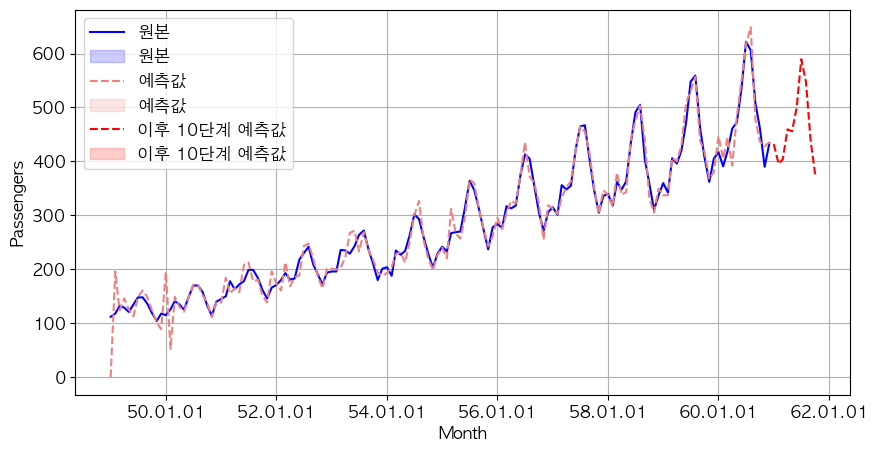

In [38]:
plt.figure()

# 원본
sb.lineplot(x=df.index, 
            y=df['Passengers'], 
            color='blue')
# 원본을 토대로 학습하여 예측한 값
sb.lineplot(x=pd.index, 
            y=pd, 
            linestyle = '--', 
            color='lightcoral')        
# 이후 10단계를 예측한 값 
sb.lineplot(x=fc.index, 
            y=fc, 
            linestyle = '--',
            color = 'red')       
plt. legend(labels=["원본", "원본","예측값", "예측값","이후 10단계 예측값", "이후 10단계 예측값"])       
plt.xlabel('Month')
plt.ylabel('Passengers')

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)
plt.grid()
plt.show()
plt.close()